# Predicting Chess Game Outcomes

## Data Loading and Exploration

In [1]:
# Load the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim  as optim
import numpy as np
import optuna
from optuna.samplers import GridSampler

In [ ]:
#Select GPu if available for processing

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using {device} for processing')



Using cpu for processing


In [3]:
# Load the csv file
df = pd.read_csv('matmob_data_sample.csv')

In [4]:
#Print shape and one example row
df.shape

(100000, 16)

In [5]:
df.head(1)

,w.mat.mean,w.mat.sd,b.mat.mean,b.mat.sd,w.mob.mean,w.mob.sd,b.mob.mean,b.mob.sd,result,valid.games.row,w.mat.vector,b.mat.vector,w.mob.vector,b.mob.vector,pgn,half.moves
0,28.166667,8.850414,28.135417,9.671031,39.3125,12.951885,27.125,11.296064,1-0,1343406,"39, 39, 39, 39, 39, 39, 39, 39, 38, 38, 38, 38...","39, 39, 39, 39, 39, 39, 39, 38, 38, 38, 38, 38...","20, 28, 30, 32, 30, 40, 40, 45, 49, 47, 49, 51...","20, 22, 28, 34, 34, 35, 31, 32, 33, 30, 30, 28...",1.d4 Nf6 2.c4 e6 3.Nf3 d5 4.cxd5 exd5 5.Qc2 Be...,95


In [6]:
df.describe()

,w.mat.mean,w.mat.sd,b.mat.mean,b.mat.sd,w.mob.mean,w.mob.sd,b.mob.mean,b.mob.sd,valid.games.row,half.moves
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000
mean,29.471540,7.518266,29.456648,7.556172,33.083914,9.300182,30.808188,8.824375,8.475512e+05,80.524530
std,5.700711,3.590136,5.722296,3.608866,4.899840,2.659605,4.488267,2.583139,4.892308e+05,33.794235
min,7.768683,0.000000,9.127049,0.000000,11.312500,1.707825,12.272727,2.387467,7.000000e+00,6.000000
25%,25.206546,4.674827,25.148607,4.691699,29.653061,7.244109,27.731616,6.879109,4.246160e+05,58.000000
50%,30.317267,7.677324,30.308824,7.716147,33.390244,9.153638,31.000000,8.740191,8.492815e+05,77.000000
75%,34.000000,10.550320,34.017938,10.608270,36.700000,11.164435,33.978723,10.618308,1.268899e+06,100.000000
max,39.000000,16.043718,39.000000,16.394856,50.842105,21.449271,48.250000,20.940381,1.696627e+06,369.000000


In [7]:
df.dtypes

w.mat.mean         float64
w.mat.sd           float64
b.mat.mean         float64
b.mat.sd           float64
w.mob.mean         float64
w.mob.sd           float64
b.mob.mean         float64
b.mob.sd           float64
result              object
valid.games.row      int64
w.mat.vector        object
b.mat.vector        object
w.mob.vector        object
b.mob.vector        object
pgn                 object
half.moves           int64
dtype: object

In [8]:
#Distribution of the result variable using value_counts()
df['result'].value_counts()

result
1-0        36485
1/2-1/2    35810
0-1        27705
Name: count, dtype: int64

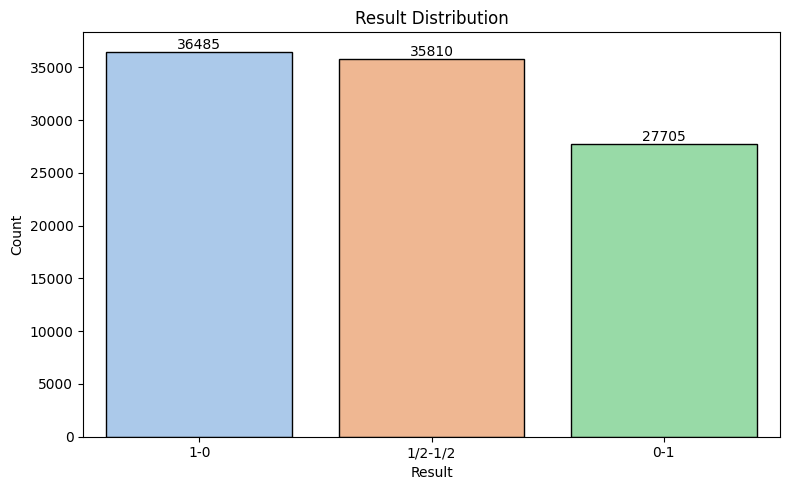

In [9]:
#A labeled bar chart of the result distribution


plt.figure(figsize=(8, 5))

data=df['result'].value_counts().index
values=list(df['result'].value_counts())
ax = sns.barplot(x=data,y=values,palette='pastel', edgecolor='black')

# Add labels on top of bars
for i, row in enumerate(data):
    ax.text(i, float(values[i])+ 0.1, values[i], ha='center', va='bottom')

# Titles and labels
plt.title('Result Distribution')
plt.xlabel('Result')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Data Preparation

In [10]:
#Retain only the following 6 columns
new_df=df[['w.mat.mean', 'b.mat.mean', 'w.mob.mean', 'b.mob.mean', 'half.moves', 'result']].copy()

new_df.head()

,w.mat.mean,b.mat.mean,w.mob.mean,b.mob.mean,half.moves,result
0,28.166667,28.135417,39.312500,27.125000,95,1-0
1,33.851852,33.703704,37.185185,33.074074,53,1-0
2,31.301587,31.920635,32.625000,37.451613,62,0-1
3,21.878261,23.260870,27.172414,32.035088,114,0-1
4,34.775510,34.959184,41.040000,32.958333,48,1/2-1/2


In [11]:
#Looking for nul values and empty values
for cols in new_df.columns:
    print(new_df[cols].loc[new_df[cols].isna()==True])
    

Series([], Name: w.mat.mean, dtype: float64)
Series([], Name: b.mat.mean, dtype: float64)
Series([], Name: w.mob.mean, dtype: float64)
Series([], Name: b.mob.mean, dtype: float64)
Series([], Name: half.moves, dtype: int64)
Series([], Name: result, dtype: object)


In [12]:
#Print the shape of new data 
new_df.shape

(100000, 6)

In [13]:
new_df.dtypes

w.mat.mean    float64
b.mat.mean    float64
w.mob.mean    float64
b.mob.mean    float64
half.moves      int64
result         object
dtype: object

In [14]:
#Look for the data characteristics
new_df.describe()

,w.mat.mean,b.mat.mean,w.mob.mean,b.mob.mean,half.moves
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,29.471540,29.456648,33.083914,30.808188,80.524530
std,5.700711,5.722296,4.899840,4.488267,33.794235
min,7.768683,9.127049,11.312500,12.272727,6.000000
25%,25.206546,25.148607,29.653061,27.731616,58.000000
50%,30.317267,30.308824,33.390244,31.000000,77.000000
75%,34.000000,34.017938,36.700000,33.978723,100.000000
max,39.000000,39.000000,50.842105,48.250000,369.000000


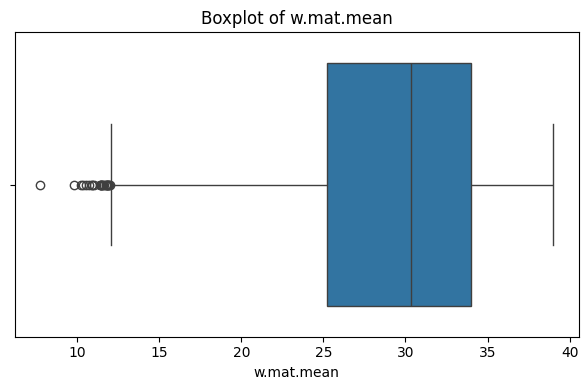

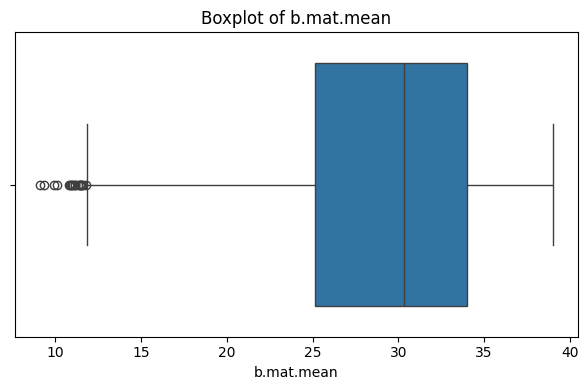

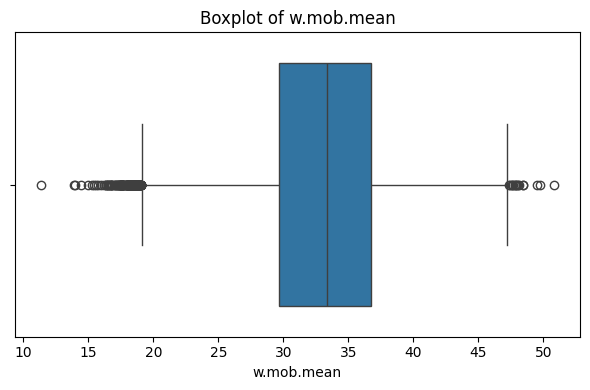

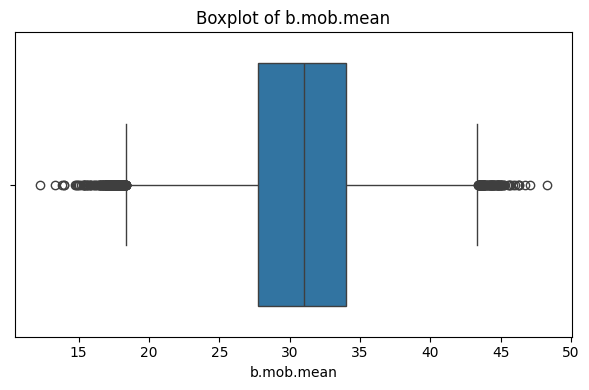

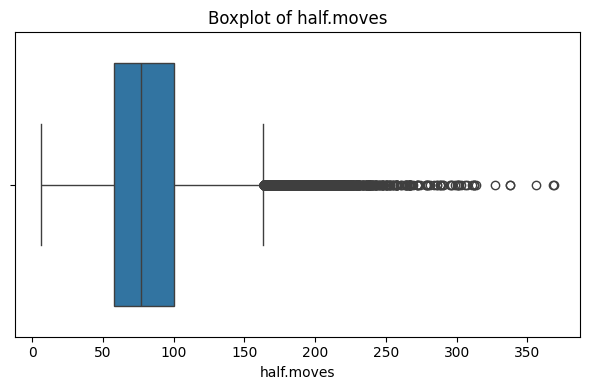

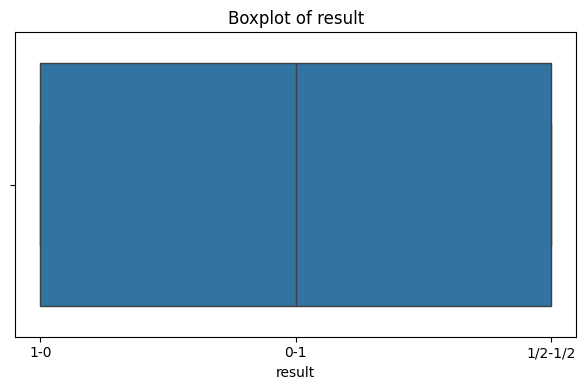

In [15]:
# looking for how the data is spread

for cols in new_df.columns:
    plt.figure(figsize=(6, 4))  # Create a new figure for each boxplot
    sns.boxplot(data=new_df, x=cols)
    plt.title(f'Boxplot of {cols}')
    plt.tight_layout()
    plt.show()

Looks like the data is spread too much and this needs to be scaled.

In [16]:
#Encode result to numeric using the following mapping
new_df.result=new_df.result.map({'1-0':int(1), '0-1':int(0), '1/2-1/2':int(2)})

In [17]:
# Perform an 85% training / 15% test split using train_test_split()
#Train test split
X_train,X_test,y_train,y_test =train_test_split(new_df.drop('result',axis=1),new_df['result'],test_size=0.15,random_state=42)

In [18]:
# Scale the 5 numeric predictor columns using StandardScaler() 
# Test upload
scalar=StandardScaler()

X_train=scalar.fit_transform(X_train)
X_test=scalar.transform(X_test)

In [19]:
# Setting up the Dataset and the Data Loader

class CustomDataSet(Dataset):
    def __init__(self,features,labels):
        self.features=torch.tensor(features,dtype=torch.float32)
        self.labels=torch.tensor(np.array(labels),dtype=torch.long)
    def __len__(self):
        return len( self.features)
    
    def __getitem__(self, index):
        return(self.features[index],self.labels[index])

train_dataset=CustomDataSet(X_train,y_train)
test_dataset=CustomDataSet(X_test,y_test)

train_loader=DataLoader(train_dataset,batch_size=128,shuffle=True,pin_memory=True)
test_loader=DataLoader(test_dataset,batch_size=128,shuffle=False,pin_memory=True)

In [20]:
#Define the Neural network Class
class MyNN(nn.Module):
    def __init__(self,input_featutes):
        super().__init__()
        self.features=nn.Sequential(
            nn.Linear(input_featutes,50),
            nn.ReLU(),
            nn.Linear(50,3),
            # nn.Softmax(dim=1)
        )

    def forward(self,x):
        x=self.features(x)
        return x

In [21]:
#Define the Learning rate and Epochs
learning_rate=0.05
epochs = 100

In [24]:

#Deine the model with the criterion and optimizer

model=MyNN(X_train.shape[1])

model.to(device)

criterion= nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)


In [25]:
# training loop
train_losses = []
train_accuracies = []
total=0
correct=0

for epoch in range(epochs):
    total_epoch_loss=0

    for batch_features,batch_labels in train_loader:

        #move data to gpu
        batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)

        #Forward pass
        outputs=model(batch_features)

        #Calculate loss
        loss= criterion(outputs,batch_labels)

        #backpass
        optimizer.zero_grad()
        loss.backward()

        #update grads
        optimizer.step()

        total_epoch_loss= total_epoch_loss+loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()
        # print(f'predicted:{predicted}Labels {batch_labels}')
    # Calculate average loss and accuracy for the epoch
    avg_loss=total_epoch_loss/len(train_loader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch {epoch +1 }, Loss: {avg_loss}')

Epoch 1, Loss: 0.9510770321788644
Epoch 2, Loss: 0.9063118030254106
Epoch 3, Loss: 0.8770132843713115
Epoch 4, Loss: 0.8480796131872593
Epoch 5, Loss: 0.8271150203575766
Epoch 6, Loss: 0.8157579376285238
Epoch 7, Loss: 0.8105275464237185
Epoch 8, Loss: 0.8076275881968047
Epoch 9, Loss: 0.8045369168869535
Epoch 10, Loss: 0.8033238260369552
Epoch 11, Loss: 0.8023423542653708
Epoch 12, Loss: 0.8015968662455566
Epoch 13, Loss: 0.8007333951785152
Epoch 14, Loss: 0.8006672166343919
Epoch 15, Loss: 0.8002849162969374
Epoch 16, Loss: 0.7999330852264749
Epoch 17, Loss: 0.7995236223801634
Epoch 18, Loss: 0.7989959576972445
Epoch 19, Loss: 0.799361607096249
Epoch 20, Loss: 0.799183190048189
Epoch 21, Loss: 0.7988316933911546
Epoch 22, Loss: 0.798204379243062
Epoch 23, Loss: 0.798596199562675
Epoch 24, Loss: 0.7983089467636625
Epoch 25, Loss: 0.7974863054160785
Epoch 26, Loss: 0.7974088469842323
Epoch 27, Loss: 0.7967109879156701
Epoch 28, Loss: 0.7966537126024863
Epoch 29, Loss: 0.796550675621606

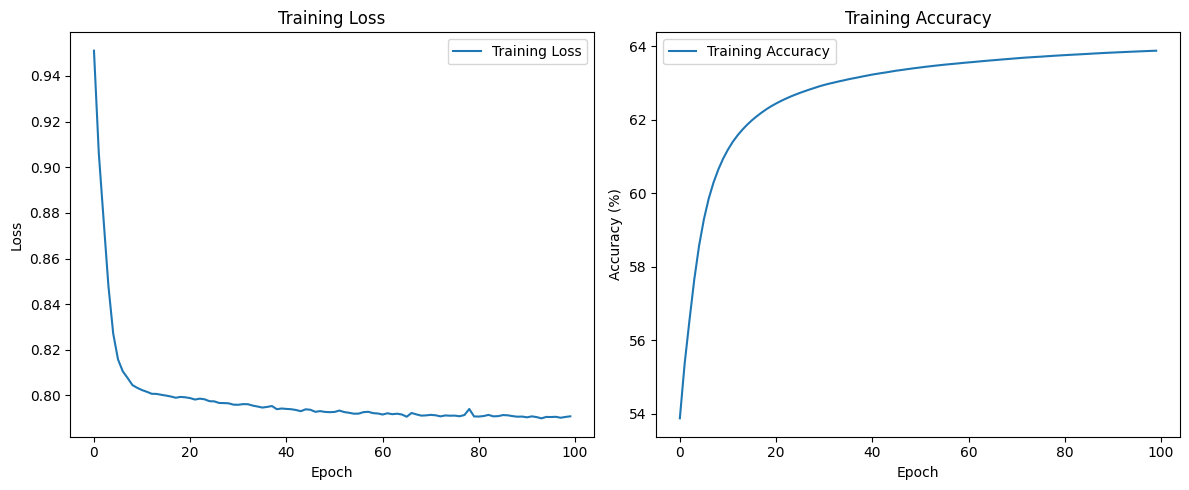

In [28]:
# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
# Evaluate and print test accuracy.

#Set model to eval model
model.eval()

#Evaluation Code

total=0
correct=0

with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        outputs=model(batch_features)
        _, predicted=torch.max(outputs,1)

        total = total + batch_labels.shape[0]
        correct= correct+(predicted==batch_labels).sum().item()
print(f'Evaluation accuracy {correct/total}')

Evaluation accuracy 0.6208666666666667


# Hyperparameter Tuning via Manual Grid Search

In [30]:
class MyNN(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_layers,neurons_per_layer,act_functn):
        super().__init__()

        layers =[]
        
        for i in range(hidden_layers):
            layers.append(nn.Linear(input_dim,neurons_per_layer))
            if act_functn=='relu':
                   layers.append(nn.ReLU())
            elif act_functn=='tanh':
                   layers.append(nn.Tanh())
            elif act_functn=='sigmoid':
                layers.append(nn.Sigmoid())
            # layers.append(nn.Dropout(drop_out_rate))
            input_dim=neurons_per_layer
        layers.append(nn.Linear(neurons_per_layer,output_dim))
        # layers.append(nn.Softmax())

        self.model=nn.Sequential(*layers)

    def forward (self,x):
        x=self.model(x)
        return (x)


In [33]:
search_space={'hidden_layers':[1,2],'neurons_per_layer':[50,60],'act_functn':['relu','tanh','sigmoid'],'optimizer_name':['Adam','SGD','RMSprop'],'learning_rate':[0.001, 0.01,0.02],'batch_size':[100,128,],'epochs':[75,100]}

#objective function

def objective(trial):
    hidden_layers=trial.suggest_categorical('hidden_layers',search_space['hidden_layers'])
    act_functn=trial.suggest_categorical('act_functn',search_space['act_functn'])
    optimizer_name=trial.suggest_categorical('optimizer_name',search_space['optimizer_name'])
    learning_rate=trial.suggest_categorical('learning_rate',search_space['learning_rate'])
    batch_size=trial.suggest_categorical('batch_size',search_space['batch_size'])
    epochs=trial.suggest_categorical('epochs',search_space['epochs'])
    neurons_per_layer=trial.suggest_categorical('neurons_per_layer',search_space['neurons_per_layer'])
    # dropout=trial.suggest_categorical('dropout',search_space['dropout'])

    input_shape=X_train.shape[1]
    output_shape=3

    model=MyNN(input_shape,output_shape,hidden_layers,neurons_per_layer,act_functn)
    model.to(device)

    #Loss Function
    criterion= nn.CrossEntropyLoss()
    

    if optimizer_name=='Adam':
        optimizer =  optim.Adam(model.parameters(),lr=learning_rate)

    elif optimizer_name=='SGD':
        optimizer =  optim.SGD(model.parameters(),lr=learning_rate)

    elif optimizer_name=='RMSprop':
        optimizer =  optim.RMSprop(model.parameters(),lr=learning_rate)
    
    # print(optimizer)


    train_loader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True,pin_memory=True)
    test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False,pin_memory=True)

    for epoch in range(epochs):
        total_epoch_loss=0
        total=0
        correct=0

        for batch_features,batch_labels in train_loader:

            #move data to gpu
            batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)

            #Forward pass
            outputs=model(batch_features)

            #Calculate loss
            loss= criterion(outputs,batch_labels)

            #backpass
            optimizer.zero_grad()
            loss.backward()

            #update grads
            optimizer.step()

            total_epoch_loss= total_epoch_loss+loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
            # print(f'predicted:{predicted}Labels {batch_labels}')
        # Calculate average loss and accuracy for the epoch
        avg_loss=total_epoch_loss/len(train_loader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(epoch_accuracy)
        print(f'Epoch {epoch +1 }, Training Loss: {avg_loss}')

        # # Plot
        # plt.figure(figsize=(12, 5))

        # plt.subplot(1, 2, 1)
        # plt.plot(train_losses, label='Training Loss')
        # plt.xlabel('Epoch')
        # plt.ylabel('Loss')
        # plt.title('Training Loss')
        # plt.legend()

        # plt.subplot(1, 2, 2)
        # plt.plot(train_accuracies, label='Training Accuracy')
        # plt.xlabel('Epoch')
        # plt.ylabel('Accuracy (%)')
        # plt.title('Training Accuracy')
        # plt.legend()

        # plt.tight_layout()
        # plt.show()

        # Evaluate and print test accuracy.

    #Set model to eval model
    model.eval()

    #Evaluation Code

    total=0
    correct=0

    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            outputs=model(batch_features)
            _, predicted=torch.max(outputs,1)

            total = total + batch_labels.shape[0]
            correct= correct+(predicted==batch_labels).sum().item()
    accuracy=correct/total
    
    # print(f'Evaluation accuracy with model parameters:  Learning rate: {learning_rate} batchsize : {batch_size} is : {accuracy}')

    return accuracy
    






In [ ]:
sampler = GridSampler(search_space)
study= optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective)

[I 2025-06-22 09:17:07,446] A new study created in memory with name: no-name-463889e4-1fec-4f03-b685-6c4cf429bb86


Epoch 1, Training Loss: 0.9802043806805331
Epoch 2, Training Loss: 0.9479877288201276
Epoch 3, Training Loss: 0.9381235287469976
Epoch 4, Training Loss: 0.9285014339054332
Epoch 5, Training Loss: 0.9188969304281123
Epoch 6, Training Loss: 0.9091485267526963
Epoch 7, Training Loss: 0.8993225637604209
Epoch 8, Training Loss: 0.8895401086526759
Epoch 9, Training Loss: 0.8799050509228425
Epoch 10, Training Loss: 0.8705633694985334
Epoch 11, Training Loss: 0.8620425023752101
Epoch 12, Training Loss: 0.8540502830813913
Epoch 13, Training Loss: 0.847077124188928
Epoch 14, Training Loss: 0.8409874964461607
Epoch 15, Training Loss: 0.8357394052954281
Epoch 16, Training Loss: 0.8312316455560572
Epoch 17, Training Loss: 0.827518512431313
Epoch 18, Training Loss: 0.8244157557627734
Epoch 19, Training Loss: 0.8219080628367031
Epoch 20, Training Loss: 0.8198740596630995
Epoch 21, Training Loss: 0.8180910734569325
Epoch 22, Training Loss: 0.8166520151671242
Epoch 23, Training Loss: 0.8155325230430154